In [1]:
import pandas as pd
from hs_gimme.db_facade.db_facade_factory import get_mongo_client_db
from hs_gimme.application_status_history_classifier.machine_learning_status_classifier import \
    get_machine_learning_status_classifier
from hs_gimme.account_settings_manager import get_account_settings
from collections import defaultdict, Counter
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ACCOUNT = 'granada'

In [3]:
mongo = get_mongo_client_db('production', ACCOUNT)

In [4]:
account_settings = get_account_settings(ACCOUNT)
phases_order_mapping = {item['id']: order for order, item in
                        enumerate(account_settings.get('candidate_phases') or [])}
#phases_order_mapping = {'new': 0, 'review': 1, 'interview': 3, 'hiring_manager_review': 2, 'offer': 4}

phases_order_mapping

{'new': 0,
 'screen': 1,
 'interview_rd1': 2,
 'interview_rd2': 3,
 'pre_offer_offer': 4,
 'pre_boarding_onboarding': 5}

In [5]:
status_cls = get_machine_learning_status_classifier('production', ACCOUNT)

In [6]:
apps = list(mongo.application.find({'samurai_json.experience': {'$gt': []},
                                 'ats_application.status_info.status_history': {'$gt': []}, }).limit(10000))

In [7]:
def get_max_phase(app):
    phases = set(status_cls.get_phases_reach_dates(app).keys()) - {'rejected'}
    if phases:
        return max(phases, key=lambda p: phases_order_mapping.get(p, -1))
    else:
        return 'NONE'

In [8]:
data = []
dirs = defaultdict(Counter)

edges = Counter()
G = nx.DiGraph()
for app in apps:
    max_status = status_cls.get_max_status(app)
    max_phase = get_max_phase(app)
    
    phases = status_cls.get_phases_reach_dates(app)
    
    prev = 'START'
    for i, (p, d) in enumerate(phases.items()):
        dirs[p][i] += 1
        
        edges[(prev, p)] += 1
        G.add_edge(prev, p)
        prev = p
        
    G.add_edge(prev, 'END')
        
        
    data.append({
        'app_id': app['_id'],
        'app': app,
        'max_status': max_status,
        'max_phase': max_phase,
        'phases': phases })
    
df = pd.DataFrame(data)

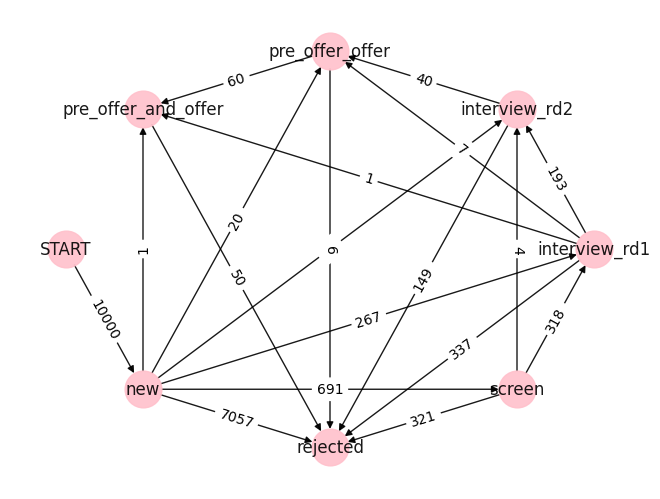

In [9]:
G = nx.DiGraph()
G.add_edges_from(edges)
pos = nx.shell_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=700, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edges,
    #font_color='green'
)
plt.draw()  # pyplot draw()

In [10]:
df['max_phase'].value_counts(normalize=True)

new                0.9005
interview_rd1      0.0385
screen             0.0369
interview_rd2      0.0174
pre_offer_offer    0.0067
Name: max_phase, dtype: float64

In [11]:
df['max_phase'].value_counts(normalize=True)

new                0.9005
interview_rd1      0.0385
screen             0.0369
interview_rd2      0.0174
pre_offer_offer    0.0067
Name: max_phase, dtype: float64

In [12]:
df[(df['max_status'] == 2) & (df['max_phase'] == 'review')]['app'].iloc[0]['ats_application']['status_info']

IndexError: single positional indexer is out-of-bounds

In [ ]:
wm = {}
for k, cnt in dirs.items():
    wm[k] = sum([p*v for p, v in cnt.items()])/sum([v for p, v in cnt.items()])

In [ ]:
for k, cnt in sorted(dirs.items(), key=lambda x: wm[x[0]]):
    print('='*3, k, '='*3, wm[k])
    print(cnt.most_common())
    print()
    

In [ ]:
{'new': 0, 'review': 1, 'interview': 3, 'hiring_manager_review': 2, 'offer': 4}

In [ ]:
lambda (x, y): np.mean(y.values())

In [ ]:
apps[0]['ats_application']['status_info']['status_history']

In [ ]:
def get_steps(app):
    if app:
        return [s.get('step_name') for s in app['ats_application']['status_info']['status_history']]

In [ ]:
df['steps'] = df['app'].apply(get_steps)

In [ ]:
sdf = df[df['max_phase'].isin({'obsolete', 'review'})]

In [ ]:
exp = sdf.explode('steps')

In [ ]:
exp['steps'].value_counts(normalize=True).to_dict()

In [ ]:
for app in apps:
    for s in app['ats_application']['status_info']['status_history']:
        print(s['step_name'])